# Session 9 - Advanced Convolutions, Data Augmentation and Visualization

The assignment evaluates the ability to design transforms using the `albumentations` library as well as designing neural networks that use dilated & depthwise separable convolutions s.t. we design a <200K parameter model to hit 85% accuracy on the CIFAR10 dataset

# Imports

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from model import Net
from utils import get_device, print_summary, visualize
from transform import get_transforms
from training import Trainer

In [2]:
device = get_device()

# Load the data

In [3]:
# First, let us identify the mean & std of standardized data to normalize
train_dset = datasets.CIFAR10(root='./data', download=True, train=True)
train_data = train_dset.data

# Standardize the data (output of transforms.ToTensor() in dataloader)
train_data = (train_data - np.min(train_data, axis=(0, 1, 2)))/\
    (np.max(train_data, axis=(0, 1, 2)) - np.min(train_data, axis=(0, 1, 2)))

# Calculate the mean & std
mean_arr = np.mean(train_data, axis=(0,1,2))
std_arr = np.std(train_data, axis=(0,1,2))

Files already downloaded and verified


In [4]:
train_transforms, test_transforms = get_transforms(mean_arr, std_arr)

In [5]:
# Download the test dataset as well
train_dset = datasets.CIFAR10(root='./data', download=True, train=True,
                              transform=train_transforms)
test_dset = datasets.CIFAR10('./data', train=False, download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define the dataloaders
torch.manual_seed(1)

# dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if use_gpu else dict(shuffle=True, batch_size=128)
dataloader_args = dict(shuffle=True, batch_size=64, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train_dset,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dset,**dataloader_args)

# Defining the network architecture

- Add skip connections (so have to create a class that has a __call__ method which performs skip connection addition)
- Dilated convolutions
- Depthwise Separable Convolutions

In [7]:
model=Net(32, 64, 128, 224)
print_summary(model)

Layer (type:depth-idx)                             Output Shape              Param #
Net                                                [1, 10]                   --
├─ConvBlock: 1-1                                   [1, 32, 16, 16]           --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─DepthwiseSeparableConv2d: 3-1          [1, 32, 32, 32]           123
│    │    └─ReLU: 3-2                              [1, 32, 32, 32]           --
│    │    └─BatchNorm2d: 3-3                       [1, 32, 32, 32]           64
│    │    └─Dropout: 3-4                           [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 32, 32]           --
│    │    └─DepthwiseSeparableConv2d: 3-5          [1, 32, 32, 32]           1,312
│    │    └─ReLU: 3-6                              [1, 32, 32, 32]           --
│    │    └─BatchNorm2d: 3-7                       [1, 32, 32, 32]           64
│    │    └─Dropout: 3-8       

# Create training & test loops

In [11]:
# Running for 150 epochs
EPOCHS = 150
MAX_LR = 0.1
model = Net(32, 64, 128, 224).to(device)
trainer = Trainer()
optimizer = optim.SGD(model.parameters(), lr=MAX_LR, momentum=0.9, weight_decay=0.000125)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, epochs=EPOCHS, final_div_factor=1e4, 
                                          steps_per_epoch=len(train_loader), pct_start=0.3)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    trainer.train(model, device, optimizer, train_loader)
    trainer.test(model, device, test_loader)
    scheduler.step()

# Save model weights
model.save()

EPOCH: 0


Loss=1.5827913284301758 Batch_id=781 Accuracy=32.51: 100%|██████████| 782/782 [00:41<00:00, 18.74it/s]



Test set: Average loss: 1.4724, Accuracy: 4660/10000 (46.60%)

EPOCH: 1


Loss=1.5064514875411987 Batch_id=781 Accuracy=42.28: 100%|██████████| 782/782 [00:41<00:00, 18.72it/s]



Test set: Average loss: 1.3219, Accuracy: 5098/10000 (50.98%)

EPOCH: 2


Loss=1.6605974435806274 Batch_id=781 Accuracy=46.51: 100%|██████████| 782/782 [00:41<00:00, 18.70it/s]



Test set: Average loss: 1.2689, Accuracy: 5282/10000 (52.82%)

EPOCH: 3


Loss=1.544323205947876 Batch_id=781 Accuracy=49.42: 100%|██████████| 782/782 [00:41<00:00, 18.77it/s] 



Test set: Average loss: 1.1591, Accuracy: 5797/10000 (57.97%)

EPOCH: 4


Loss=1.451269507408142 Batch_id=781 Accuracy=51.78: 100%|██████████| 782/782 [00:41<00:00, 18.81it/s] 



Test set: Average loss: 1.1056, Accuracy: 6068/10000 (60.68%)

EPOCH: 5


Loss=1.3214902877807617 Batch_id=781 Accuracy=54.08: 100%|██████████| 782/782 [00:41<00:00, 18.80it/s]



Test set: Average loss: 1.0957, Accuracy: 6118/10000 (61.18%)

EPOCH: 6


Loss=1.162842869758606 Batch_id=781 Accuracy=55.87: 100%|██████████| 782/782 [00:41<00:00, 18.62it/s] 



Test set: Average loss: 0.9859, Accuracy: 6432/10000 (64.32%)

EPOCH: 7


Loss=1.566727876663208 Batch_id=781 Accuracy=57.61: 100%|██████████| 782/782 [00:45<00:00, 17.29it/s] 



Test set: Average loss: 0.9446, Accuracy: 6579/10000 (65.79%)

EPOCH: 8


Loss=1.3249390125274658 Batch_id=781 Accuracy=58.97: 100%|██████████| 782/782 [00:43<00:00, 17.88it/s]



Test set: Average loss: 0.9433, Accuracy: 6657/10000 (66.57%)

EPOCH: 9


Loss=1.2750873565673828 Batch_id=781 Accuracy=60.23: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s]



Test set: Average loss: 0.8892, Accuracy: 6855/10000 (68.55%)

EPOCH: 10


Loss=1.1793783903121948 Batch_id=781 Accuracy=61.69: 100%|██████████| 782/782 [00:43<00:00, 17.95it/s]



Test set: Average loss: 0.8543, Accuracy: 6959/10000 (69.59%)

EPOCH: 11


Loss=0.8156685829162598 Batch_id=781 Accuracy=62.44: 100%|██████████| 782/782 [00:43<00:00, 17.87it/s]



Test set: Average loss: 0.8227, Accuracy: 7081/10000 (70.81%)

EPOCH: 12


Loss=0.8629987835884094 Batch_id=781 Accuracy=63.16: 100%|██████████| 782/782 [00:43<00:00, 17.87it/s]



Test set: Average loss: 0.7934, Accuracy: 7235/10000 (72.35%)

EPOCH: 13


Loss=0.8961291909217834 Batch_id=781 Accuracy=64.02: 100%|██████████| 782/782 [00:43<00:00, 17.94it/s]



Test set: Average loss: 0.7921, Accuracy: 7212/10000 (72.12%)

EPOCH: 14


Loss=1.0864934921264648 Batch_id=781 Accuracy=64.92: 100%|██████████| 782/782 [00:43<00:00, 17.96it/s]



Test set: Average loss: 0.7742, Accuracy: 7281/10000 (72.81%)

EPOCH: 15


Loss=0.6195396184921265 Batch_id=781 Accuracy=65.52: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s]



Test set: Average loss: 0.7619, Accuracy: 7380/10000 (73.80%)

EPOCH: 16


Loss=1.4008913040161133 Batch_id=781 Accuracy=66.19: 100%|██████████| 782/782 [00:43<00:00, 17.94it/s]



Test set: Average loss: 0.7435, Accuracy: 7445/10000 (74.45%)

EPOCH: 17


Loss=0.8951444625854492 Batch_id=781 Accuracy=66.69: 100%|██████████| 782/782 [00:44<00:00, 17.75it/s]



Test set: Average loss: 0.7362, Accuracy: 7421/10000 (74.21%)

EPOCH: 18


Loss=1.1600162982940674 Batch_id=781 Accuracy=67.33: 100%|██████████| 782/782 [00:44<00:00, 17.74it/s]



Test set: Average loss: 0.7095, Accuracy: 7553/10000 (75.53%)

EPOCH: 19


Loss=1.0415213108062744 Batch_id=781 Accuracy=67.75: 100%|██████████| 782/782 [00:44<00:00, 17.49it/s]



Test set: Average loss: 0.7037, Accuracy: 7539/10000 (75.39%)

EPOCH: 20


Loss=1.1126686334609985 Batch_id=781 Accuracy=68.09: 100%|██████████| 782/782 [00:45<00:00, 17.32it/s]



Test set: Average loss: 0.6873, Accuracy: 7612/10000 (76.12%)

EPOCH: 21


Loss=0.8841547966003418 Batch_id=781 Accuracy=68.20: 100%|██████████| 782/782 [00:45<00:00, 17.15it/s]



Test set: Average loss: 0.6804, Accuracy: 7643/10000 (76.43%)

EPOCH: 22


Loss=0.7821639776229858 Batch_id=781 Accuracy=68.82: 100%|██████████| 782/782 [00:45<00:00, 17.14it/s]



Test set: Average loss: 0.6798, Accuracy: 7649/10000 (76.49%)

EPOCH: 23


Loss=1.0170783996582031 Batch_id=781 Accuracy=68.94: 100%|██████████| 782/782 [00:45<00:00, 17.17it/s] 



Test set: Average loss: 0.6646, Accuracy: 7695/10000 (76.95%)

EPOCH: 24


Loss=1.1397075653076172 Batch_id=781 Accuracy=69.33: 100%|██████████| 782/782 [00:45<00:00, 17.02it/s]



Test set: Average loss: 0.6635, Accuracy: 7706/10000 (77.06%)

EPOCH: 25


Loss=0.8363169431686401 Batch_id=781 Accuracy=69.33: 100%|██████████| 782/782 [00:46<00:00, 16.92it/s] 



Test set: Average loss: 0.6732, Accuracy: 7687/10000 (76.87%)

EPOCH: 26


Loss=1.0478627681732178 Batch_id=781 Accuracy=69.69: 100%|██████████| 782/782 [02:22<00:00,  5.50it/s]  



Test set: Average loss: 0.6370, Accuracy: 7785/10000 (77.85%)

EPOCH: 27


Loss=0.7041712999343872 Batch_id=781 Accuracy=70.31: 100%|██████████| 782/782 [08:04<00:00,  1.61it/s]  



Test set: Average loss: 0.6360, Accuracy: 7808/10000 (78.08%)

EPOCH: 28


Loss=0.8110694289207458 Batch_id=781 Accuracy=70.06: 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]



Test set: Average loss: 0.6336, Accuracy: 7755/10000 (77.55%)

EPOCH: 29


Loss=0.9790158271789551 Batch_id=781 Accuracy=70.32: 100%|██████████| 782/782 [08:09<00:00,  1.60it/s] 



Test set: Average loss: 0.6227, Accuracy: 7829/10000 (78.29%)

EPOCH: 30


Loss=0.6675657629966736 Batch_id=781 Accuracy=70.82: 100%|██████████| 782/782 [00:39<00:00, 19.71it/s] 



Test set: Average loss: 0.6318, Accuracy: 7810/10000 (78.10%)

EPOCH: 31


Loss=0.9801487326622009 Batch_id=781 Accuracy=71.09: 100%|██████████| 782/782 [00:39<00:00, 19.68it/s]



Test set: Average loss: 0.6269, Accuracy: 7835/10000 (78.35%)

EPOCH: 32


Loss=0.7738333344459534 Batch_id=781 Accuracy=70.99: 100%|██████████| 782/782 [16:37<00:00,  1.28s/it]   



Test set: Average loss: 0.6419, Accuracy: 7752/10000 (77.52%)

EPOCH: 33


Loss=1.0219906568527222 Batch_id=781 Accuracy=71.34: 100%|██████████| 782/782 [00:39<00:00, 19.69it/s]



Test set: Average loss: 0.6138, Accuracy: 7877/10000 (78.77%)

EPOCH: 34


Loss=0.7227770090103149 Batch_id=781 Accuracy=71.44: 100%|██████████| 782/782 [00:39<00:00, 19.59it/s] 



Test set: Average loss: 0.6121, Accuracy: 7860/10000 (78.60%)

EPOCH: 35


Loss=0.5651389360427856 Batch_id=781 Accuracy=71.72: 100%|██████████| 782/782 [00:39<00:00, 19.69it/s] 



Test set: Average loss: 0.6119, Accuracy: 7890/10000 (78.90%)

EPOCH: 36


Loss=0.7072252035140991 Batch_id=781 Accuracy=71.90: 100%|██████████| 782/782 [05:34<00:00,  2.34it/s]  



Test set: Average loss: 0.5961, Accuracy: 7920/10000 (79.20%)

EPOCH: 37


Loss=1.216786503791809 Batch_id=781 Accuracy=72.04: 100%|██████████| 782/782 [00:39<00:00, 19.66it/s]  



Test set: Average loss: 0.6100, Accuracy: 7884/10000 (78.84%)

EPOCH: 38


Loss=0.773552656173706 Batch_id=781 Accuracy=72.49: 100%|██████████| 782/782 [00:39<00:00, 19.56it/s]  



Test set: Average loss: 0.6052, Accuracy: 7902/10000 (79.02%)

EPOCH: 39


Loss=0.8432238698005676 Batch_id=781 Accuracy=72.45: 100%|██████████| 782/782 [00:39<00:00, 19.60it/s] 



Test set: Average loss: 0.5899, Accuracy: 7956/10000 (79.56%)

EPOCH: 40


Loss=0.8393650054931641 Batch_id=781 Accuracy=72.09: 100%|██████████| 782/782 [01:34<00:00,  8.25it/s] 



Test set: Average loss: 0.5848, Accuracy: 8012/10000 (80.12%)

EPOCH: 41


Loss=0.4731706380844116 Batch_id=781 Accuracy=72.64: 100%|██████████| 782/782 [00:39<00:00, 19.73it/s] 



Test set: Average loss: 0.5799, Accuracy: 8019/10000 (80.19%)

EPOCH: 42


Loss=1.6770782470703125 Batch_id=781 Accuracy=72.88: 100%|██████████| 782/782 [00:39<00:00, 19.72it/s] 



Test set: Average loss: 0.5732, Accuracy: 8048/10000 (80.48%)

EPOCH: 43


Loss=0.6046450138092041 Batch_id=781 Accuracy=72.81: 100%|██████████| 782/782 [15:40<00:00,  1.20s/it]    



Test set: Average loss: 0.5697, Accuracy: 8059/10000 (80.59%)

EPOCH: 44


Loss=0.975469708442688 Batch_id=781 Accuracy=73.43: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]  



Test set: Average loss: 0.5827, Accuracy: 7969/10000 (79.69%)

EPOCH: 45


Loss=0.7427496910095215 Batch_id=781 Accuracy=73.22: 100%|██████████| 782/782 [00:39<00:00, 19.69it/s] 



Test set: Average loss: 0.5849, Accuracy: 8010/10000 (80.10%)

EPOCH: 46


Loss=0.6717256307601929 Batch_id=781 Accuracy=73.71: 100%|██████████| 782/782 [00:39<00:00, 19.65it/s] 



Test set: Average loss: 0.5748, Accuracy: 8059/10000 (80.59%)

EPOCH: 47


Loss=1.2814996242523193 Batch_id=781 Accuracy=73.49: 100%|██████████| 782/782 [01:48<00:00,  7.24it/s]  



Test set: Average loss: 0.5797, Accuracy: 8001/10000 (80.01%)

EPOCH: 48


Loss=0.8440199494361877 Batch_id=781 Accuracy=73.63: 100%|██████████| 782/782 [00:39<00:00, 19.73it/s] 



Test set: Average loss: 0.5557, Accuracy: 8102/10000 (81.02%)

EPOCH: 49


Loss=1.0789673328399658 Batch_id=781 Accuracy=73.61: 100%|██████████| 782/782 [00:39<00:00, 19.71it/s] 



Test set: Average loss: 0.5587, Accuracy: 8034/10000 (80.34%)

EPOCH: 50


Loss=1.1426711082458496 Batch_id=781 Accuracy=73.88: 100%|██████████| 782/782 [04:21<00:00,  3.00it/s]  



Test set: Average loss: 0.5533, Accuracy: 8080/10000 (80.80%)

EPOCH: 51


Loss=1.0081923007965088 Batch_id=781 Accuracy=73.72: 100%|██████████| 782/782 [00:41<00:00, 18.63it/s] 



Test set: Average loss: 0.5524, Accuracy: 8117/10000 (81.17%)

EPOCH: 52


Loss=0.821320652961731 Batch_id=781 Accuracy=74.16: 100%|██████████| 782/782 [00:41<00:00, 18.88it/s]  



Test set: Average loss: 0.5497, Accuracy: 8091/10000 (80.91%)

EPOCH: 53


Loss=0.9777326583862305 Batch_id=781 Accuracy=74.03: 100%|██████████| 782/782 [00:41<00:00, 18.92it/s] 



Test set: Average loss: 0.5468, Accuracy: 8147/10000 (81.47%)

EPOCH: 54


Loss=0.7872260808944702 Batch_id=781 Accuracy=73.98: 100%|██████████| 782/782 [00:41<00:00, 18.92it/s] 



Test set: Average loss: 0.5548, Accuracy: 8130/10000 (81.30%)

EPOCH: 55


Loss=0.5561015605926514 Batch_id=781 Accuracy=74.36: 100%|██████████| 782/782 [00:41<00:00, 18.93it/s] 



Test set: Average loss: 0.5389, Accuracy: 8128/10000 (81.28%)

EPOCH: 56


Loss=0.643478274345398 Batch_id=781 Accuracy=74.53: 100%|██████████| 782/782 [00:41<00:00, 18.95it/s]  



Test set: Average loss: 0.5684, Accuracy: 8070/10000 (80.70%)

EPOCH: 57


Loss=0.8549522161483765 Batch_id=781 Accuracy=74.64: 100%|██████████| 782/782 [00:41<00:00, 18.95it/s] 



Test set: Average loss: 0.5428, Accuracy: 8153/10000 (81.53%)

EPOCH: 58


Loss=0.8589496612548828 Batch_id=781 Accuracy=74.57: 100%|██████████| 782/782 [00:42<00:00, 18.20it/s] 



Test set: Average loss: 0.5507, Accuracy: 8095/10000 (80.95%)

EPOCH: 59


Loss=1.3359994888305664 Batch_id=781 Accuracy=74.62: 100%|██████████| 782/782 [00:43<00:00, 17.99it/s] 



Test set: Average loss: 0.5438, Accuracy: 8134/10000 (81.34%)

EPOCH: 60


Loss=1.361572027206421 Batch_id=781 Accuracy=74.65: 100%|██████████| 782/782 [00:43<00:00, 17.93it/s]  



Test set: Average loss: 0.5389, Accuracy: 8193/10000 (81.93%)

EPOCH: 61


Loss=0.9007457494735718 Batch_id=781 Accuracy=74.91: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.5719, Accuracy: 8059/10000 (80.59%)

EPOCH: 62


Loss=1.0800166130065918 Batch_id=781 Accuracy=74.86: 100%|██████████| 782/782 [00:43<00:00, 17.97it/s] 



Test set: Average loss: 0.5471, Accuracy: 8120/10000 (81.20%)

EPOCH: 63


Loss=0.6152617931365967 Batch_id=781 Accuracy=74.96: 100%|██████████| 782/782 [00:43<00:00, 17.99it/s] 



Test set: Average loss: 0.5405, Accuracy: 8136/10000 (81.36%)

EPOCH: 64


Loss=0.7008157968521118 Batch_id=781 Accuracy=74.85: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.5336, Accuracy: 8198/10000 (81.98%)

EPOCH: 65


Loss=0.8994332551956177 Batch_id=781 Accuracy=75.33: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.5382, Accuracy: 8146/10000 (81.46%)

EPOCH: 66


Loss=1.0964298248291016 Batch_id=781 Accuracy=75.46: 100%|██████████| 782/782 [00:43<00:00, 17.97it/s] 



Test set: Average loss: 0.5297, Accuracy: 8177/10000 (81.77%)

EPOCH: 67


Loss=0.8054713010787964 Batch_id=781 Accuracy=75.27: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.5238, Accuracy: 8228/10000 (82.28%)

EPOCH: 68


Loss=0.5686236619949341 Batch_id=781 Accuracy=75.26: 100%|██████████| 782/782 [00:43<00:00, 17.96it/s] 



Test set: Average loss: 0.5373, Accuracy: 8175/10000 (81.75%)

EPOCH: 69


Loss=0.42057597637176514 Batch_id=781 Accuracy=75.22: 100%|██████████| 782/782 [00:43<00:00, 17.99it/s]



Test set: Average loss: 0.5251, Accuracy: 8205/10000 (82.05%)

EPOCH: 70


Loss=0.5012518763542175 Batch_id=781 Accuracy=75.74: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.5313, Accuracy: 8196/10000 (81.96%)

EPOCH: 71


Loss=0.5584695339202881 Batch_id=781 Accuracy=75.58: 100%|██████████| 782/782 [00:43<00:00, 17.96it/s] 



Test set: Average loss: 0.5264, Accuracy: 8228/10000 (82.28%)

EPOCH: 72


Loss=0.5307996869087219 Batch_id=781 Accuracy=75.51: 100%|██████████| 782/782 [00:43<00:00, 17.96it/s] 



Test set: Average loss: 0.5206, Accuracy: 8245/10000 (82.45%)

EPOCH: 73


Loss=0.5475337505340576 Batch_id=781 Accuracy=75.54: 100%|██████████| 782/782 [00:43<00:00, 17.95it/s] 



Test set: Average loss: 0.5336, Accuracy: 8157/10000 (81.57%)

EPOCH: 74


Loss=0.9561412930488586 Batch_id=781 Accuracy=75.56: 100%|██████████| 782/782 [00:41<00:00, 18.73it/s] 



Test set: Average loss: 0.5077, Accuracy: 8288/10000 (82.88%)

EPOCH: 75


Loss=0.5179579257965088 Batch_id=781 Accuracy=75.81: 100%|██████████| 782/782 [00:41<00:00, 18.64it/s] 



Test set: Average loss: 0.5263, Accuracy: 8201/10000 (82.01%)

EPOCH: 76


Loss=0.975881814956665 Batch_id=781 Accuracy=76.00: 100%|██████████| 782/782 [00:41<00:00, 18.79it/s]  



Test set: Average loss: 0.5235, Accuracy: 8244/10000 (82.44%)

EPOCH: 77


Loss=0.7785948514938354 Batch_id=781 Accuracy=75.68: 100%|██████████| 782/782 [00:42<00:00, 18.39it/s] 



Test set: Average loss: 0.5270, Accuracy: 8185/10000 (81.85%)

EPOCH: 78


Loss=0.7937952280044556 Batch_id=781 Accuracy=75.89: 100%|██████████| 782/782 [00:41<00:00, 18.79it/s] 



Test set: Average loss: 0.5322, Accuracy: 8160/10000 (81.60%)

EPOCH: 79


Loss=0.8146224617958069 Batch_id=781 Accuracy=76.08: 100%|██████████| 782/782 [00:42<00:00, 18.42it/s] 



Test set: Average loss: 0.5148, Accuracy: 8232/10000 (82.32%)

EPOCH: 80


Loss=0.4429231882095337 Batch_id=781 Accuracy=75.81: 100%|██████████| 782/782 [00:43<00:00, 18.18it/s] 



Test set: Average loss: 0.5131, Accuracy: 8214/10000 (82.14%)

EPOCH: 81


Loss=1.0558058023452759 Batch_id=781 Accuracy=76.47: 100%|██████████| 782/782 [00:43<00:00, 18.01it/s] 



Test set: Average loss: 0.5304, Accuracy: 8203/10000 (82.03%)

EPOCH: 82


Loss=0.6048592329025269 Batch_id=781 Accuracy=76.17: 100%|██████████| 782/782 [00:41<00:00, 18.67it/s] 



Test set: Average loss: 0.5040, Accuracy: 8266/10000 (82.66%)

EPOCH: 83


Loss=0.6274759769439697 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [00:42<00:00, 18.35it/s] 



Test set: Average loss: 0.5319, Accuracy: 8191/10000 (81.91%)

EPOCH: 84


Loss=0.5488680005073547 Batch_id=781 Accuracy=76.47: 100%|██████████| 782/782 [00:42<00:00, 18.40it/s] 



Test set: Average loss: 0.5046, Accuracy: 8267/10000 (82.67%)

EPOCH: 85


Loss=0.4280637502670288 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:43<00:00, 18.17it/s] 



Test set: Average loss: 0.5044, Accuracy: 8297/10000 (82.97%)

EPOCH: 86


Loss=0.8918288350105286 Batch_id=781 Accuracy=76.05: 100%|██████████| 782/782 [00:44<00:00, 17.70it/s] 



Test set: Average loss: 0.5100, Accuracy: 8242/10000 (82.42%)

EPOCH: 87


Loss=0.2988405227661133 Batch_id=781 Accuracy=76.54: 100%|██████████| 782/782 [00:45<00:00, 17.36it/s] 



Test set: Average loss: 0.5010, Accuracy: 8277/10000 (82.77%)

EPOCH: 88


Loss=0.8176311254501343 Batch_id=781 Accuracy=76.48: 100%|██████████| 782/782 [00:56<00:00, 13.96it/s] 



Test set: Average loss: 0.5135, Accuracy: 8214/10000 (82.14%)

EPOCH: 89


Loss=0.4864991009235382 Batch_id=781 Accuracy=76.22: 100%|██████████| 782/782 [00:43<00:00, 17.83it/s] 



Test set: Average loss: 0.5184, Accuracy: 8193/10000 (81.93%)

EPOCH: 90


Loss=0.5899583697319031 Batch_id=781 Accuracy=76.70: 100%|██████████| 782/782 [00:44<00:00, 17.76it/s] 



Test set: Average loss: 0.5077, Accuracy: 8258/10000 (82.58%)

EPOCH: 91


Loss=0.5077543258666992 Batch_id=781 Accuracy=76.71: 100%|██████████| 782/782 [00:43<00:00, 17.85it/s] 



Test set: Average loss: 0.5041, Accuracy: 8288/10000 (82.88%)

EPOCH: 92


Loss=0.9518564939498901 Batch_id=781 Accuracy=76.72: 100%|██████████| 782/782 [00:43<00:00, 18.03it/s] 



Test set: Average loss: 0.5036, Accuracy: 8248/10000 (82.48%)

EPOCH: 93


Loss=1.2422010898590088 Batch_id=781 Accuracy=76.55: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.5223, Accuracy: 8243/10000 (82.43%)

EPOCH: 94


Loss=1.0677464008331299 Batch_id=781 Accuracy=76.95: 100%|██████████| 782/782 [00:43<00:00, 17.86it/s] 



Test set: Average loss: 0.5123, Accuracy: 8248/10000 (82.48%)

EPOCH: 95


Loss=1.0961607694625854 Batch_id=781 Accuracy=76.71: 100%|██████████| 782/782 [00:46<00:00, 16.83it/s] 



Test set: Average loss: 0.5112, Accuracy: 8230/10000 (82.30%)

EPOCH: 96


Loss=0.5404602885246277 Batch_id=781 Accuracy=76.72: 100%|██████████| 782/782 [00:45<00:00, 17.10it/s] 



Test set: Average loss: 0.5001, Accuracy: 8269/10000 (82.69%)

EPOCH: 97


Loss=0.7405120134353638 Batch_id=781 Accuracy=76.96: 100%|██████████| 782/782 [00:45<00:00, 17.29it/s] 



Test set: Average loss: 0.5040, Accuracy: 8313/10000 (83.13%)

EPOCH: 98


Loss=0.7071194648742676 Batch_id=781 Accuracy=76.77: 100%|██████████| 782/782 [00:45<00:00, 17.34it/s] 



Test set: Average loss: 0.5196, Accuracy: 8235/10000 (82.35%)

EPOCH: 99


Loss=0.6700927019119263 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:45<00:00, 17.37it/s] 



Test set: Average loss: 0.5032, Accuracy: 8270/10000 (82.70%)

EPOCH: 100


Loss=1.2828067541122437 Batch_id=781 Accuracy=76.81: 100%|██████████| 782/782 [00:44<00:00, 17.47it/s] 



Test set: Average loss: 0.4962, Accuracy: 8277/10000 (82.77%)

EPOCH: 101


Loss=0.615778386592865 Batch_id=781 Accuracy=76.85: 100%|██████████| 782/782 [00:44<00:00, 17.48it/s]  



Test set: Average loss: 0.4931, Accuracy: 8312/10000 (83.12%)

EPOCH: 102


Loss=1.7142293453216553 Batch_id=781 Accuracy=77.06: 100%|██████████| 782/782 [00:46<00:00, 16.99it/s] 



Test set: Average loss: 0.5122, Accuracy: 8257/10000 (82.57%)

EPOCH: 103


Loss=0.54395991563797 Batch_id=781 Accuracy=77.14: 100%|██████████| 782/782 [00:46<00:00, 16.91it/s]   



Test set: Average loss: 0.5141, Accuracy: 8215/10000 (82.15%)

EPOCH: 104


Loss=0.9187979102134705 Batch_id=781 Accuracy=77.14: 100%|██████████| 782/782 [00:46<00:00, 17.00it/s] 



Test set: Average loss: 0.5102, Accuracy: 8302/10000 (83.02%)

EPOCH: 105


Loss=0.7396750450134277 Batch_id=781 Accuracy=77.05: 100%|██████████| 782/782 [00:46<00:00, 16.85it/s] 



Test set: Average loss: 0.5147, Accuracy: 8229/10000 (82.29%)

EPOCH: 106


Loss=0.941753089427948 Batch_id=781 Accuracy=77.16: 100%|██████████| 782/782 [00:46<00:00, 16.97it/s]  



Test set: Average loss: 0.5155, Accuracy: 8244/10000 (82.44%)

EPOCH: 107


Loss=0.6538640260696411 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [00:46<00:00, 16.86it/s] 



Test set: Average loss: 0.5063, Accuracy: 8293/10000 (82.93%)

EPOCH: 108


Loss=0.6645090579986572 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:46<00:00, 16.80it/s] 



Test set: Average loss: 0.5062, Accuracy: 8296/10000 (82.96%)

EPOCH: 109


Loss=0.5162191390991211 Batch_id=781 Accuracy=77.05: 100%|██████████| 782/782 [00:46<00:00, 16.85it/s] 



Test set: Average loss: 0.5102, Accuracy: 8257/10000 (82.57%)

EPOCH: 110


Loss=0.49528220295906067 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:46<00:00, 16.89it/s]



Test set: Average loss: 0.5037, Accuracy: 8307/10000 (83.07%)

EPOCH: 111


Loss=0.941163182258606 Batch_id=781 Accuracy=77.34: 100%|██████████| 782/782 [00:46<00:00, 16.89it/s]  



Test set: Average loss: 0.5212, Accuracy: 8235/10000 (82.35%)

EPOCH: 112


Loss=0.47371435165405273 Batch_id=781 Accuracy=77.46: 100%|██████████| 782/782 [00:46<00:00, 16.94it/s]



Test set: Average loss: 0.5010, Accuracy: 8313/10000 (83.13%)

EPOCH: 113


Loss=0.4270775318145752 Batch_id=781 Accuracy=77.40: 100%|██████████| 782/782 [00:46<00:00, 16.91it/s] 



Test set: Average loss: 0.5132, Accuracy: 8258/10000 (82.58%)

EPOCH: 114


Loss=0.8326905369758606 Batch_id=781 Accuracy=77.20: 100%|██████████| 782/782 [00:46<00:00, 16.80it/s] 



Test set: Average loss: 0.5016, Accuracy: 8315/10000 (83.15%)

EPOCH: 115


Loss=0.7855380773544312 Batch_id=781 Accuracy=77.59: 100%|██████████| 782/782 [00:46<00:00, 16.81it/s] 



Test set: Average loss: 0.5002, Accuracy: 8280/10000 (82.80%)

EPOCH: 116


Loss=0.9922282695770264 Batch_id=781 Accuracy=77.46: 100%|██████████| 782/782 [00:46<00:00, 16.86it/s] 



Test set: Average loss: 0.4976, Accuracy: 8371/10000 (83.71%)

EPOCH: 117


Loss=1.0532965660095215 Batch_id=781 Accuracy=77.69: 100%|██████████| 782/782 [00:46<00:00, 16.91it/s] 



Test set: Average loss: 0.4976, Accuracy: 8349/10000 (83.49%)

EPOCH: 118


Loss=0.5985167026519775 Batch_id=781 Accuracy=77.73: 100%|██████████| 782/782 [00:46<00:00, 16.76it/s] 



Test set: Average loss: 0.5036, Accuracy: 8278/10000 (82.78%)

EPOCH: 119


Loss=1.0333137512207031 Batch_id=781 Accuracy=77.90: 100%|██████████| 782/782 [00:46<00:00, 16.86it/s] 



Test set: Average loss: 0.5032, Accuracy: 8296/10000 (82.96%)

EPOCH: 120


Loss=0.4440707564353943 Batch_id=781 Accuracy=77.45: 100%|██████████| 782/782 [00:46<00:00, 16.84it/s] 



Test set: Average loss: 0.4893, Accuracy: 8343/10000 (83.43%)

EPOCH: 121


Loss=0.5756390690803528 Batch_id=781 Accuracy=77.93: 100%|██████████| 782/782 [00:43<00:00, 17.88it/s] 



Test set: Average loss: 0.4988, Accuracy: 8329/10000 (83.29%)

EPOCH: 122


Loss=1.1740938425064087 Batch_id=781 Accuracy=77.53: 100%|██████████| 782/782 [00:42<00:00, 18.44it/s] 



Test set: Average loss: 0.5088, Accuracy: 8257/10000 (82.57%)

EPOCH: 123


Loss=1.191184163093567 Batch_id=781 Accuracy=77.55: 100%|██████████| 782/782 [00:41<00:00, 18.69it/s]  



Test set: Average loss: 0.5144, Accuracy: 8241/10000 (82.41%)

EPOCH: 124


Loss=1.4207556247711182 Batch_id=781 Accuracy=78.01: 100%|██████████| 782/782 [00:44<00:00, 17.43it/s] 



Test set: Average loss: 0.5021, Accuracy: 8298/10000 (82.98%)

EPOCH: 125


Loss=0.5693173408508301 Batch_id=781 Accuracy=77.95: 100%|██████████| 782/782 [00:46<00:00, 16.73it/s] 



Test set: Average loss: 0.5017, Accuracy: 8326/10000 (83.26%)

EPOCH: 126


Loss=1.0038998126983643 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [00:45<00:00, 17.14it/s] 



Test set: Average loss: 0.4877, Accuracy: 8342/10000 (83.42%)

EPOCH: 127


Loss=0.6204411387443542 Batch_id=781 Accuracy=77.94: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s] 



Test set: Average loss: 0.4899, Accuracy: 8371/10000 (83.71%)

EPOCH: 128


Loss=0.4456758499145508 Batch_id=781 Accuracy=78.20: 100%|██████████| 782/782 [00:43<00:00, 17.90it/s] 



Test set: Average loss: 0.4900, Accuracy: 8368/10000 (83.68%)

EPOCH: 129


Loss=0.7934670448303223 Batch_id=781 Accuracy=77.86: 100%|██████████| 782/782 [00:42<00:00, 18.34it/s] 



Test set: Average loss: 0.4955, Accuracy: 8344/10000 (83.44%)

EPOCH: 130


Loss=1.3830009698867798 Batch_id=781 Accuracy=78.16: 100%|██████████| 782/782 [00:44<00:00, 17.73it/s] 



Test set: Average loss: 0.4814, Accuracy: 8360/10000 (83.60%)

EPOCH: 131


Loss=0.7029702663421631 Batch_id=781 Accuracy=77.76: 100%|██████████| 782/782 [00:42<00:00, 18.40it/s] 



Test set: Average loss: 0.4899, Accuracy: 8353/10000 (83.53%)

EPOCH: 132


Loss=1.0084428787231445 Batch_id=781 Accuracy=77.95: 100%|██████████| 782/782 [00:42<00:00, 18.25it/s] 



Test set: Average loss: 0.4849, Accuracy: 8346/10000 (83.46%)

EPOCH: 133


Loss=0.7117133140563965 Batch_id=781 Accuracy=78.06: 100%|██████████| 782/782 [00:42<00:00, 18.33it/s] 



Test set: Average loss: 0.4895, Accuracy: 8341/10000 (83.41%)

EPOCH: 134


Loss=0.36010438203811646 Batch_id=781 Accuracy=78.15: 100%|██████████| 782/782 [00:42<00:00, 18.37it/s]



Test set: Average loss: 0.4942, Accuracy: 8344/10000 (83.44%)

EPOCH: 135


Loss=1.0839736461639404 Batch_id=781 Accuracy=78.10: 100%|██████████| 782/782 [00:44<00:00, 17.49it/s] 



Test set: Average loss: 0.4859, Accuracy: 8392/10000 (83.92%)

EPOCH: 136


Loss=0.9680576920509338 Batch_id=781 Accuracy=77.96: 100%|██████████| 782/782 [00:45<00:00, 17.19it/s] 



Test set: Average loss: 0.4998, Accuracy: 8331/10000 (83.31%)

EPOCH: 137


Loss=1.0302430391311646 Batch_id=781 Accuracy=78.23: 100%|██████████| 782/782 [00:46<00:00, 16.78it/s] 



Test set: Average loss: 0.5021, Accuracy: 8344/10000 (83.44%)

EPOCH: 138


Loss=1.12404465675354 Batch_id=781 Accuracy=78.02: 100%|██████████| 782/782 [00:46<00:00, 16.97it/s]   



Test set: Average loss: 0.5135, Accuracy: 8240/10000 (82.40%)

EPOCH: 139


Loss=0.4396168887615204 Batch_id=781 Accuracy=77.78: 100%|██████████| 782/782 [00:47<00:00, 16.48it/s] 



Test set: Average loss: 0.4826, Accuracy: 8361/10000 (83.61%)

EPOCH: 140


Loss=0.31918179988861084 Batch_id=781 Accuracy=78.30: 100%|██████████| 782/782 [00:44<00:00, 17.52it/s]



Test set: Average loss: 0.4903, Accuracy: 8324/10000 (83.24%)

EPOCH: 141


Loss=0.8707132339477539 Batch_id=781 Accuracy=78.40: 100%|██████████| 782/782 [00:44<00:00, 17.60it/s] 



Test set: Average loss: 0.4908, Accuracy: 8328/10000 (83.28%)

EPOCH: 142


Loss=0.6356667876243591 Batch_id=781 Accuracy=78.17: 100%|██████████| 782/782 [00:43<00:00, 17.79it/s] 



Test set: Average loss: 0.4878, Accuracy: 8336/10000 (83.36%)

EPOCH: 143


Loss=0.41273626685142517 Batch_id=781 Accuracy=78.39: 100%|██████████| 782/782 [00:44<00:00, 17.42it/s]



Test set: Average loss: 0.4814, Accuracy: 8364/10000 (83.64%)

EPOCH: 144


Loss=0.5159066319465637 Batch_id=781 Accuracy=78.44: 100%|██████████| 782/782 [00:44<00:00, 17.52it/s] 



Test set: Average loss: 0.5058, Accuracy: 8321/10000 (83.21%)

EPOCH: 145


Loss=0.38319993019104004 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:45<00:00, 17.26it/s]



Test set: Average loss: 0.4886, Accuracy: 8346/10000 (83.46%)

EPOCH: 146


Loss=0.7894298434257507 Batch_id=781 Accuracy=78.41: 100%|██████████| 782/782 [00:44<00:00, 17.42it/s] 



Test set: Average loss: 0.4791, Accuracy: 8372/10000 (83.72%)

EPOCH: 147


Loss=0.6288421750068665 Batch_id=781 Accuracy=78.26: 100%|██████████| 782/782 [00:45<00:00, 17.16it/s] 



Test set: Average loss: 0.4926, Accuracy: 8359/10000 (83.59%)

EPOCH: 148


Loss=0.46146929264068604 Batch_id=781 Accuracy=78.68: 100%|██████████| 782/782 [00:45<00:00, 17.34it/s]



Test set: Average loss: 0.5054, Accuracy: 8299/10000 (82.99%)

EPOCH: 149


Loss=0.44454240798950195 Batch_id=781 Accuracy=78.39: 100%|██████████| 782/782 [00:45<00:00, 17.23it/s]



Test set: Average loss: 0.4883, Accuracy: 8372/10000 (83.72%)



In [13]:
# Training for another 50 epochs with a lower max LR and same Trainer class
EPOCHS = 50
MAX_LR = 0.01

optimizer = optim.SGD(model.parameters(), lr=MAX_LR, momentum=0.9, weight_decay=0.000125)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, epochs=EPOCHS, final_div_factor=1e4, 
                                          steps_per_epoch=len(train_loader), pct_start=0.3)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    trainer.train(model, device, optimizer, train_loader)
    trainer.test(model, device, test_loader)
    scheduler.step()
model.save()

EPOCH: 0


Loss=0.7941778898239136 Batch_id=781 Accuracy=80.18: 100%|██████████| 782/782 [00:42<00:00, 18.45it/s] 



Test set: Average loss: 0.4538, Accuracy: 8496/10000 (84.96%)

EPOCH: 1


Loss=0.7820924520492554 Batch_id=781 Accuracy=80.61: 100%|██████████| 782/782 [00:41<00:00, 18.67it/s] 



Test set: Average loss: 0.4542, Accuracy: 8510/10000 (85.10%)

EPOCH: 2


Loss=0.6804521083831787 Batch_id=781 Accuracy=81.11: 100%|██████████| 782/782 [00:41<00:00, 18.69it/s] 



Test set: Average loss: 0.4477, Accuracy: 8518/10000 (85.18%)

EPOCH: 3


Loss=1.2305227518081665 Batch_id=781 Accuracy=81.14: 100%|██████████| 782/782 [00:42<00:00, 18.58it/s] 



Test set: Average loss: 0.4498, Accuracy: 8533/10000 (85.33%)

EPOCH: 4


Loss=0.7740939259529114 Batch_id=781 Accuracy=81.34: 100%|██████████| 782/782 [00:41<00:00, 18.70it/s] 



Test set: Average loss: 0.4432, Accuracy: 8516/10000 (85.16%)

EPOCH: 5


Loss=0.8191770911216736 Batch_id=781 Accuracy=81.79: 100%|██████████| 782/782 [00:41<00:00, 18.73it/s] 



Test set: Average loss: 0.4470, Accuracy: 8497/10000 (84.97%)

EPOCH: 6


Loss=0.5148468017578125 Batch_id=781 Accuracy=81.74: 100%|██████████| 782/782 [00:41<00:00, 18.67it/s] 



Test set: Average loss: 0.4424, Accuracy: 8533/10000 (85.33%)

EPOCH: 7


Loss=0.4844907820224762 Batch_id=781 Accuracy=81.67: 100%|██████████| 782/782 [00:42<00:00, 18.23it/s] 



Test set: Average loss: 0.4404, Accuracy: 8526/10000 (85.26%)

EPOCH: 8


Loss=0.42981305718421936 Batch_id=781 Accuracy=81.73: 100%|██████████| 782/782 [00:43<00:00, 17.82it/s]



Test set: Average loss: 0.4423, Accuracy: 8535/10000 (85.35%)

EPOCH: 9


Loss=0.49468016624450684 Batch_id=781 Accuracy=81.88: 100%|██████████| 782/782 [00:43<00:00, 17.79it/s]



Test set: Average loss: 0.4486, Accuracy: 8532/10000 (85.32%)

EPOCH: 10


Loss=0.18757635354995728 Batch_id=781 Accuracy=81.80: 100%|██████████| 782/782 [00:43<00:00, 17.92it/s]



Test set: Average loss: 0.4389, Accuracy: 8538/10000 (85.38%)

EPOCH: 11


Loss=0.8644070029258728 Batch_id=781 Accuracy=81.91: 100%|██████████| 782/782 [00:43<00:00, 17.97it/s] 



Test set: Average loss: 0.4440, Accuracy: 8542/10000 (85.42%)

EPOCH: 12


Loss=0.7597962021827698 Batch_id=781 Accuracy=81.95: 100%|██████████| 782/782 [00:43<00:00, 17.98it/s] 



Test set: Average loss: 0.4476, Accuracy: 8525/10000 (85.25%)

EPOCH: 13


Loss=0.4987490773200989 Batch_id=781 Accuracy=82.00: 100%|██████████| 782/782 [00:43<00:00, 17.97it/s] 



Test set: Average loss: 0.4397, Accuracy: 8548/10000 (85.48%)

EPOCH: 14


Loss=0.19397133588790894 Batch_id=781 Accuracy=81.90: 100%|██████████| 782/782 [00:43<00:00, 17.97it/s]



Test set: Average loss: 0.4436, Accuracy: 8527/10000 (85.27%)

EPOCH: 15


Loss=0.560704231262207 Batch_id=781 Accuracy=82.02: 100%|██████████| 782/782 [00:43<00:00, 17.94it/s]  



Test set: Average loss: 0.4410, Accuracy: 8564/10000 (85.64%)

EPOCH: 16


Loss=0.15022465586662292 Batch_id=781 Accuracy=82.02: 100%|██████████| 782/782 [00:42<00:00, 18.43it/s]



Test set: Average loss: 0.4364, Accuracy: 8560/10000 (85.60%)

EPOCH: 17


Loss=0.8158385753631592 Batch_id=781 Accuracy=82.06: 100%|██████████| 782/782 [00:41<00:00, 18.76it/s] 



Test set: Average loss: 0.4431, Accuracy: 8544/10000 (85.44%)

EPOCH: 18


Loss=0.5291605591773987 Batch_id=781 Accuracy=81.76: 100%|██████████| 782/782 [00:42<00:00, 18.55it/s] 



Test set: Average loss: 0.4430, Accuracy: 8538/10000 (85.38%)

EPOCH: 19


Loss=0.5357405543327332 Batch_id=781 Accuracy=82.33: 100%|██████████| 782/782 [00:42<00:00, 18.41it/s] 



Test set: Average loss: 0.4429, Accuracy: 8557/10000 (85.57%)

EPOCH: 20


Loss=0.35307085514068604 Batch_id=781 Accuracy=82.11: 100%|██████████| 782/782 [00:43<00:00, 18.15it/s]



Test set: Average loss: 0.4409, Accuracy: 8541/10000 (85.41%)

EPOCH: 21


Loss=0.7545850276947021 Batch_id=781 Accuracy=82.40: 100%|██████████| 782/782 [00:42<00:00, 18.43it/s] 



Test set: Average loss: 0.4395, Accuracy: 8553/10000 (85.53%)

EPOCH: 22


Loss=0.6103957295417786 Batch_id=781 Accuracy=82.21: 100%|██████████| 782/782 [00:41<00:00, 18.93it/s] 



Test set: Average loss: 0.4445, Accuracy: 8542/10000 (85.42%)

EPOCH: 23


Loss=0.44937974214553833 Batch_id=781 Accuracy=82.27: 100%|██████████| 782/782 [00:42<00:00, 18.26it/s]



Test set: Average loss: 0.4418, Accuracy: 8548/10000 (85.48%)

EPOCH: 24


Loss=0.3384838402271271 Batch_id=781 Accuracy=82.31: 100%|██████████| 782/782 [00:42<00:00, 18.45it/s] 



Test set: Average loss: 0.4409, Accuracy: 8516/10000 (85.16%)

EPOCH: 25


Loss=0.6929911971092224 Batch_id=781 Accuracy=82.05: 100%|██████████| 782/782 [00:41<00:00, 18.70it/s] 



Test set: Average loss: 0.4465, Accuracy: 8547/10000 (85.47%)

EPOCH: 26


Loss=0.36410778760910034 Batch_id=781 Accuracy=82.44: 100%|██████████| 782/782 [00:43<00:00, 17.92it/s]



Test set: Average loss: 0.4443, Accuracy: 8543/10000 (85.43%)

EPOCH: 27


Loss=0.40287578105926514 Batch_id=781 Accuracy=82.43: 100%|██████████| 782/782 [00:42<00:00, 18.61it/s]



Test set: Average loss: 0.4457, Accuracy: 8551/10000 (85.51%)

EPOCH: 28


Loss=0.6481671333312988 Batch_id=781 Accuracy=82.26: 100%|██████████| 782/782 [00:42<00:00, 18.51it/s] 



Test set: Average loss: 0.4389, Accuracy: 8559/10000 (85.59%)

EPOCH: 29


Loss=0.3421609401702881 Batch_id=781 Accuracy=82.26: 100%|██████████| 782/782 [00:42<00:00, 18.39it/s] 



Test set: Average loss: 0.4443, Accuracy: 8525/10000 (85.25%)

EPOCH: 30


Loss=0.34763091802597046 Batch_id=781 Accuracy=82.61: 100%|██████████| 782/782 [00:45<00:00, 17.20it/s]



Test set: Average loss: 0.4427, Accuracy: 8570/10000 (85.70%)

EPOCH: 31


Loss=0.565883457660675 Batch_id=781 Accuracy=82.44: 100%|██████████| 782/782 [00:44<00:00, 17.52it/s]  



Test set: Average loss: 0.4424, Accuracy: 8545/10000 (85.45%)

EPOCH: 32


Loss=0.2826595604419708 Batch_id=781 Accuracy=82.58: 100%|██████████| 782/782 [00:45<00:00, 17.33it/s] 



Test set: Average loss: 0.4421, Accuracy: 8540/10000 (85.40%)

EPOCH: 33


Loss=0.6312391757965088 Batch_id=781 Accuracy=82.28: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s] 



Test set: Average loss: 0.4426, Accuracy: 8538/10000 (85.38%)

EPOCH: 34


Loss=0.28607290983200073 Batch_id=781 Accuracy=82.54: 100%|██████████| 782/782 [00:44<00:00, 17.53it/s]



Test set: Average loss: 0.4450, Accuracy: 8549/10000 (85.49%)

EPOCH: 35


Loss=1.0650503635406494 Batch_id=781 Accuracy=82.37: 100%|██████████| 782/782 [00:47<00:00, 16.56it/s] 



Test set: Average loss: 0.4458, Accuracy: 8539/10000 (85.39%)

EPOCH: 36


Loss=0.8267660140991211 Batch_id=781 Accuracy=82.53: 100%|██████████| 782/782 [00:45<00:00, 17.15it/s] 



Test set: Average loss: 0.4479, Accuracy: 8538/10000 (85.38%)

EPOCH: 37


Loss=0.6719740033149719 Batch_id=781 Accuracy=82.55: 100%|██████████| 782/782 [00:45<00:00, 17.20it/s] 



Test set: Average loss: 0.4420, Accuracy: 8573/10000 (85.73%)

EPOCH: 38


Loss=0.4916015863418579 Batch_id=781 Accuracy=82.91: 100%|██████████| 782/782 [00:45<00:00, 17.20it/s] 



Test set: Average loss: 0.4399, Accuracy: 8574/10000 (85.74%)

EPOCH: 39


Loss=0.8530260324478149 Batch_id=781 Accuracy=82.75: 100%|██████████| 782/782 [00:45<00:00, 17.17it/s] 



Test set: Average loss: 0.4392, Accuracy: 8563/10000 (85.63%)

EPOCH: 40


Loss=0.7625583410263062 Batch_id=781 Accuracy=82.54: 100%|██████████| 782/782 [00:45<00:00, 17.17it/s] 



Test set: Average loss: 0.4395, Accuracy: 8564/10000 (85.64%)

EPOCH: 41


Loss=1.1022379398345947 Batch_id=781 Accuracy=82.67: 100%|██████████| 782/782 [00:46<00:00, 16.88it/s] 



Test set: Average loss: 0.4464, Accuracy: 8543/10000 (85.43%)

EPOCH: 42


Loss=0.6393101215362549 Batch_id=781 Accuracy=82.60: 100%|██████████| 782/782 [00:46<00:00, 16.81it/s] 



Test set: Average loss: 0.4406, Accuracy: 8559/10000 (85.59%)

EPOCH: 43


Loss=0.6010522842407227 Batch_id=781 Accuracy=82.79: 100%|██████████| 782/782 [00:47<00:00, 16.43it/s] 



Test set: Average loss: 0.4424, Accuracy: 8549/10000 (85.49%)

EPOCH: 44


Loss=0.21063604950904846 Batch_id=781 Accuracy=82.45: 100%|██████████| 782/782 [00:46<00:00, 16.98it/s]



Test set: Average loss: 0.4416, Accuracy: 8548/10000 (85.48%)

EPOCH: 45


Loss=0.8377407789230347 Batch_id=781 Accuracy=82.75: 100%|██████████| 782/782 [00:46<00:00, 16.83it/s] 



Test set: Average loss: 0.4402, Accuracy: 8560/10000 (85.60%)

EPOCH: 46


Loss=0.9320441484451294 Batch_id=781 Accuracy=82.78: 100%|██████████| 782/782 [00:47<00:00, 16.49it/s] 



Test set: Average loss: 0.4400, Accuracy: 8549/10000 (85.49%)

EPOCH: 47


Loss=0.28375035524368286 Batch_id=781 Accuracy=82.85: 100%|██████████| 782/782 [00:50<00:00, 15.59it/s]



Test set: Average loss: 0.4442, Accuracy: 8554/10000 (85.54%)

EPOCH: 48


Loss=1.5306658744812012 Batch_id=781 Accuracy=82.74: 100%|██████████| 782/782 [00:47<00:00, 16.47it/s] 



Test set: Average loss: 0.4410, Accuracy: 8574/10000 (85.74%)

EPOCH: 49


Loss=0.7973708510398865 Batch_id=781 Accuracy=82.54: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s] 



Test set: Average loss: 0.4374, Accuracy: 8579/10000 (85.79%)



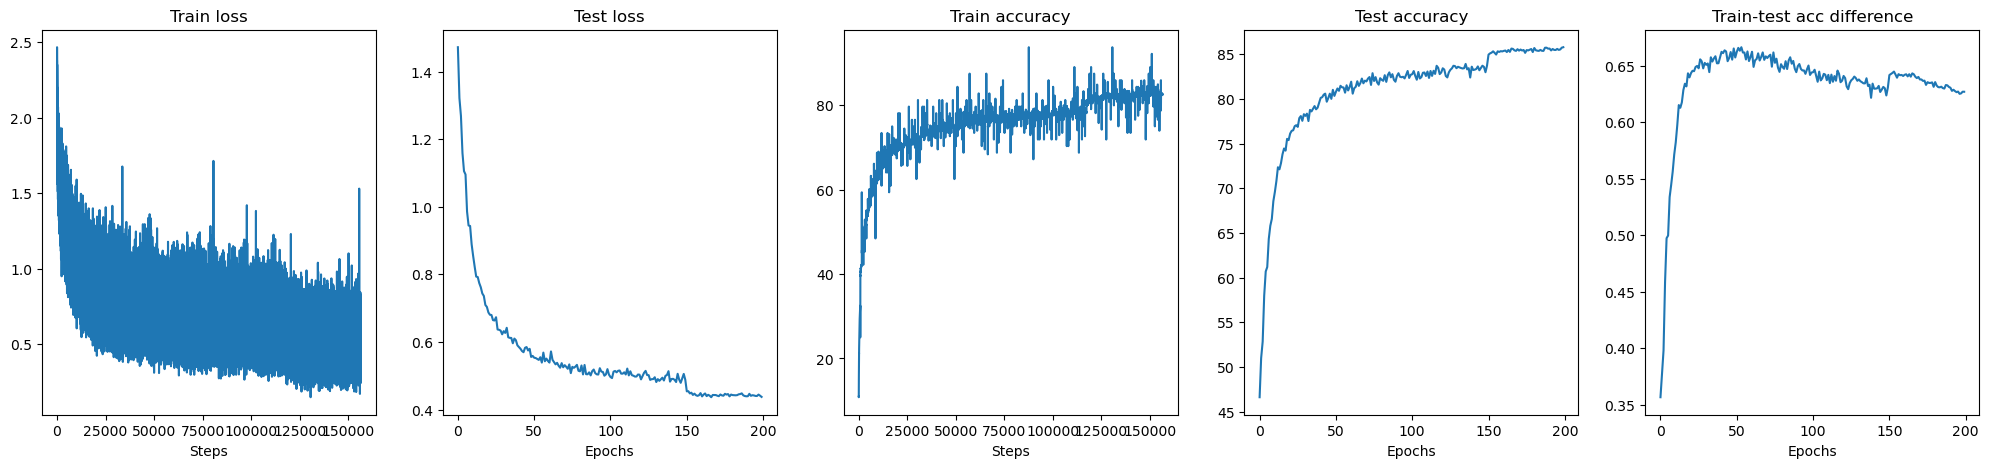

In [14]:
# Let's check for overfitting visually
visualize(trainer)